In [50]:
import site

site.addsitedir("../src")

from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

In [43]:
outdir = Path("/Users/davidzheng/projects/crew-ai/outdirs/0525/run_7")

dfs = [pd.read_pickle(x) for x in outdir.glob("task_infos/task_info_*.pkl")]
task_df = pd.concat(x["task"] for x in dfs).sort_index()
game_df = pd.concat(x["game"] for x in dfs).sort_index()
game_df["win_rate"] = game_df["game_win"] / game_df["count"]

In [73]:
import numpy as np
from scipy.stats import theilslopes


def _index_to_float(idx: pd.Index) -> np.ndarray:
    """
    Convert a monotonic pandas index to float values suitable for regression.
    * DatetimeIndex → seconds since epoch
    * Everything else → float64 cast
    """
    if np.issubdtype(idx.dtype, np.datetime64):
        return idx.astype("int64") / 1e9  # seconds
    return idx.to_numpy(dtype="float64")


def _theil_sen_slope(y: pd.Series) -> float:
    x = _index_to_float(y.index)
    slope, *_ = theilslopes(y.to_numpy(), x)
    return slope


def rolling_robust_slopes(df: pd.DataFrame, window: int, method="theil"):
    func = _theil_sen_slope
    return df.apply(
        lambda col: col.rolling(window, min_periods=window).apply(func, raw=False)
    )

In [69]:
def distance_from_first_cummax(df: pd.DataFrame, min_improve=0.005) -> pd.DataFrame:
    ret = {}
    for c in df:
        ret[c] = []
        best_idx, best_val = 0, 0.0
        for idx, val in df[c].items():
            if val >= best_val + min_improve:
                best_idx = idx
                best_val = val
            ret[c].append(idx - best_idx)

    return pd.DataFrame(ret, index=df.index)

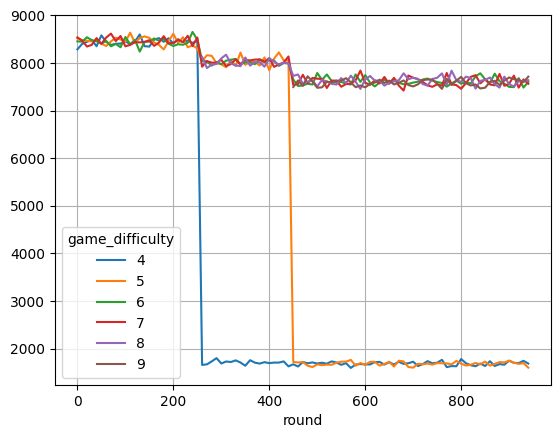

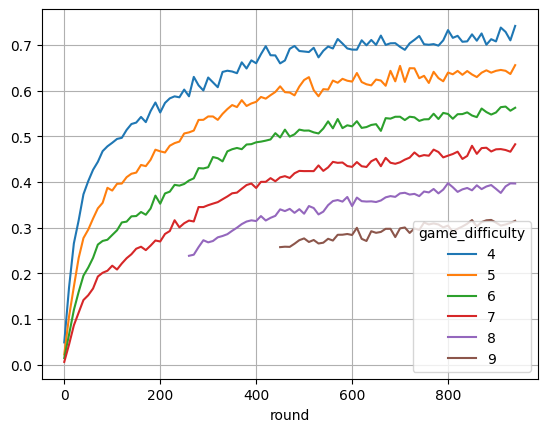

In [63]:
game_df["count"].unstack("game_difficulty").plot(grid=True)
plt.show()
game_df["win_rate"].unstack("game_difficulty").plot(grid=True)
plt.show()

<Axes: xlabel='round'>

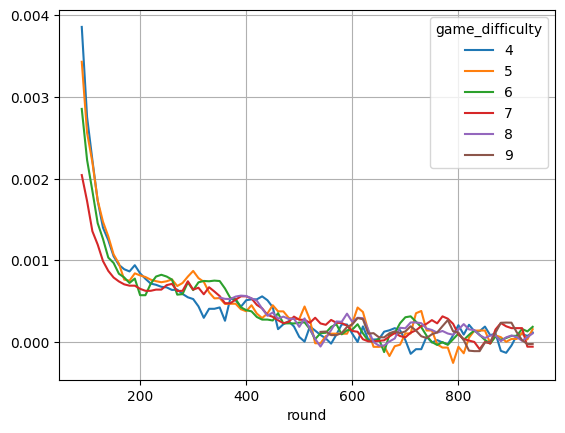

In [78]:
game_df["win_rate"].unstack("game_difficulty").pipe(
    rolling_robust_slopes, window=10
).plot(grid=True)

<Axes: xlabel='round'>

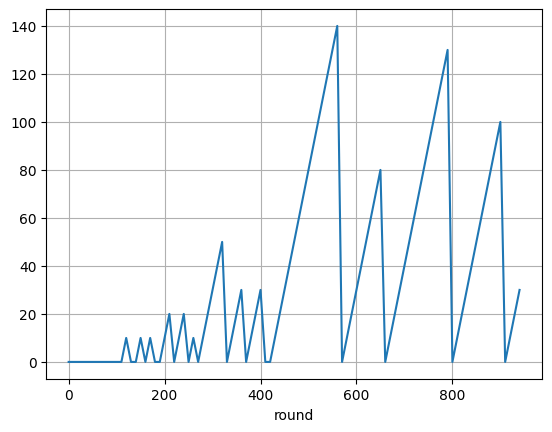

In [71]:
win_rate = game_df["win_rate"].unstack("game_difficulty")
distance_from_first_cummax(win_rate)[4].plot(grid=True)

<Axes: xlabel='round'>

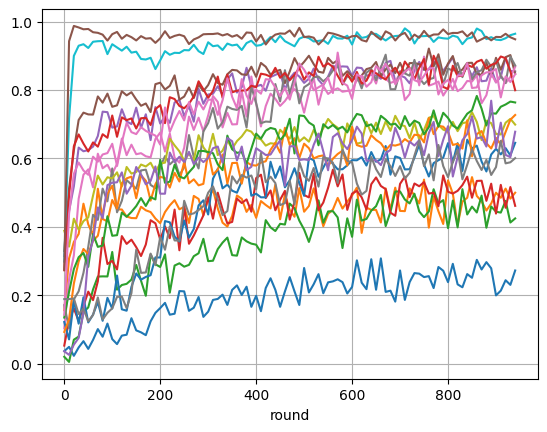

In [95]:
task_df.xs(7, level="game_difficulty").assign(
    success_rate=lambda df: df["task_success"] / df["count"]
)["success_rate"].unstack("task_idx").sample(frac=0.2, axis=1).plot(
    legend=False, grid=True
)